In [59]:
%load_ext autoreload
%autoreload 2

import torch
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm, trange

from models.transformer import Aggregator
from models.tokenizer import *
from models.vggt import *
from heads.camera_head import *
from heads.depth_head import *

from dataloader.preprocessing import *
from dataloader.dataset import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
def savefig(fig, name=None):
    if name is None:
        name = input("Plot name (empty = do not save):").strip()
        if len(name) == 0:
            print("Empty name received, did not save.")

    path = f"figs/{name}.png"

    if os.path.exists(path) and input(f"{path} exists. Overwrite? [y/N] ").lower() != "y":
        return
    
    fig.savefig(path)
    print(f"Saved to path {path}")

# Main training test

In [61]:
# can I even load the big one
# path = "/sdf/home/y/youngsam/data/dune/larnet/h5/DataAccessExamples/train/generic_v2_51800_v1.h5"
path = "/sdf/home/y/youngsam/data/dune/larnet/h5/DataAccessExamples/tutorial_example_v1.h5"
dataset = dataset_from_file(path, remove_noise_cluster=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Loaded {len(dataset)} events")

Loaded 10 events


In [62]:
# This value of L is used solely to scale the depths. Maybe it should be scaled somewhere else
L = 768

In [88]:
# Initialize model and associated optimizer
model = VGGT(
    tokenizer = IdentityTokenizer(),
    aggregator = Aggregator(embed_dim=256),
    depth_head = DepthHeadOnlyFC(dim_in=512)
)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters())

iteration = 0

history = list()

TypeError: _BatchNorm.__init__() missing 1 required positional argument: 'num_features'

In [76]:
print_every = 10
iterations = 100

for i in range(iterations):
    # Take a sample
    start = time.perf_counter()
    sample, rotations = dataset.choose_events(10, 3, locked_rotations="limited")
    patch_counts, all_coords, all_patches, all_depths = stack_patches(sample)
    patch_counts = torch.Tensor(patch_counts).int().to(device)
    all_coords = torch.Tensor(all_coords).int().to(device)
    all_patches = torch.Tensor(all_patches).to(device)
    all_depths = torch.Tensor(all_depths).to(device) / L
    
    # Zero gradients
    optimizer.zero_grad()
    
    # Make predictions
    predictions, test_output, patch_start_idx = model(patch_counts, all_coords, all_patches)
    pred_depths = predictions["depth"]
    # pred_quaternions = predictions["pose_enc"]
    
    # # Compute the ground truth quaternions
    # inverse_first = [x[0].inv() for x in rotations]
    # corrected_rotations = [[x*first for x in row] for first, row in zip(inverse_first, rotations)]
    # quaternions = torch.tensor(np.array([[r.as_quat() for r in row] for row in corrected_rotations])).to(device).float()
    
    # Run backprop
    # loss = loss_fn(pred_quaternions, quaternions)
    mask = all_patches > 0
    loss = torch.sum(mask * torch.square(pred_depths - all_depths)) / torch.sum(mask)
    # loss = torch.sum(mask * torch.square(pred_depths - all_patches)) / torch.sum(mask)
    loss.backward()
    optimizer.step()
    end = time.perf_counter()
    
    if print_every is not None and i % print_every == 0:
        # Print loss
        print(f"i={i}, loss={loss.item()}, time={end-start:.2f}s")

history.append(loss.item())

i=0, loss=0.04418927803635597, time=0.72s
i=10, loss=0.04471249505877495, time=0.68s
i=20, loss=0.04442363977432251, time=0.68s
i=30, loss=0.04559709131717682, time=0.68s
i=40, loss=0.04507751762866974, time=0.69s
i=50, loss=0.042969271540641785, time=0.67s
i=60, loss=0.04449314624071121, time=0.69s
i=70, loss=0.043531741946935654, time=0.88s
i=80, loss=0.042798832058906555, time=0.69s
i=90, loss=0.04274796321988106, time=0.69s


In [82]:
model.depth_head.fc[2].weight.grad

tensor([[ 2.7424e-06,  2.5984e-06,  4.8927e-06,  ...,  2.4092e-05,
          5.3435e-06,  8.4800e-07],
        [ 4.7175e-06,  3.5646e-06,  6.8704e-06,  ...,  3.6621e-05,
          7.6383e-06,  1.2325e-06],
        [-3.4205e-06, -1.8986e-06, -3.0776e-06,  ..., -2.0233e-05,
         -5.4641e-06, -1.9592e-06],
        ...,
        [-1.9354e-06, -7.4313e-07, -1.0174e-06,  ..., -7.1232e-06,
         -1.8230e-06, -9.2766e-07],
        [-3.0229e-06, -4.3415e-07, -5.7801e-06,  ..., -1.0072e-05,
         -8.6738e-07, -6.2494e-07],
        [ 6.2472e-06,  9.3194e-06,  5.6450e-06,  ...,  2.1658e-05,
          1.0811e-05,  5.4461e-06]], device='cuda:0')

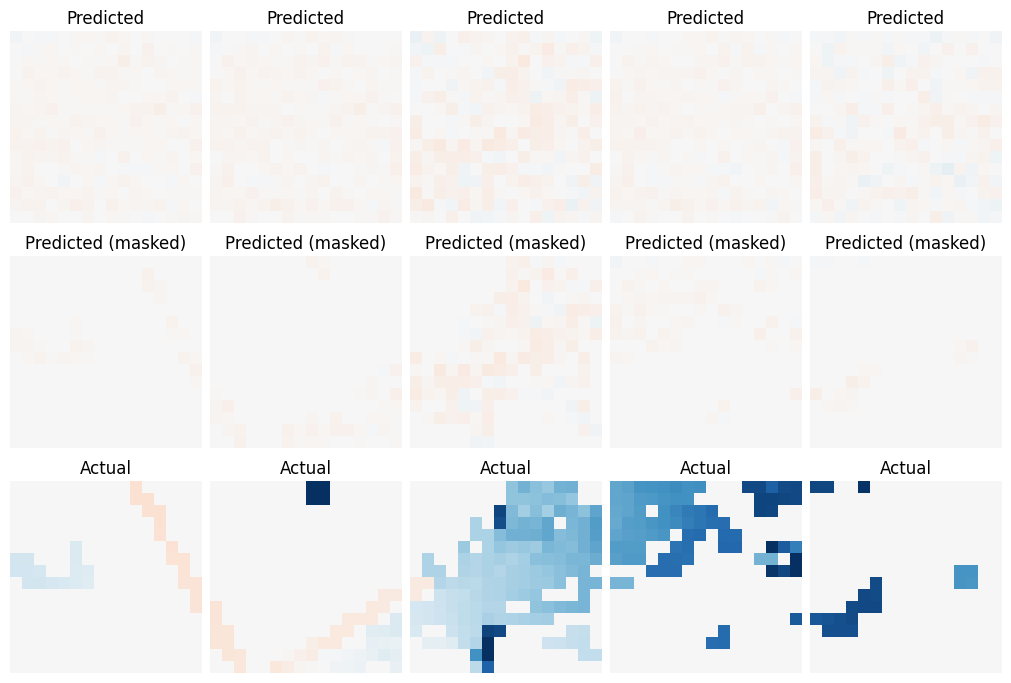

In [78]:
# Graph a set of results over rows

patch_counts, all_coords, all_patches, all_depths = stack_patches(sample)
patch_counts = torch.Tensor(patch_counts).int().to(device)
all_coords = torch.Tensor(all_coords).int().to(device)
all_patches = torch.Tensor(all_patches).to(device)
all_depths = torch.Tensor(all_depths).to(device) / L

# Make predictions
predictions, test_output, patch_start_idx = model(patch_counts, all_coords, all_patches)
pred_depths = predictions["depth"]

mask = all_patches > 0

# Display a given number of tests
n_tests = 5
d_tests = 2
fig, axes = plt.subplots(figsize=(2*n_tests, 6.75), ncols=n_tests, nrows=3, layout="constrained")
for test_i in range(n_tests):
    sample_i = n_tests*d_tests + test_i
    ax1, ax2, ax3 = axes[:,test_i]
    c = ax1.imshow((pred_depths[sample_i]).detach().cpu().numpy(), origin='lower', cmap='RdBu', vmin=-0.5, vmax=0.5)
    c = ax2.imshow((pred_depths[sample_i] * mask[sample_i]).detach().cpu().numpy(), origin='lower', cmap='RdBu', vmin=-0.5, vmax=0.5)
    c = ax3.imshow((all_depths[sample_i]).detach().cpu().numpy(), origin='lower', cmap='RdBu', vmin=-0.5, vmax=0.5)
    ax1.set_title("Predicted")
    ax2.set_title("Predicted (masked)")
    ax3.set_title("Actual")
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')

In [254]:
# saved_hists = list()

In [289]:
saved_hists.append(history)

current contents: original, with joint tokenizer, with tanh instead, CNN with tanh

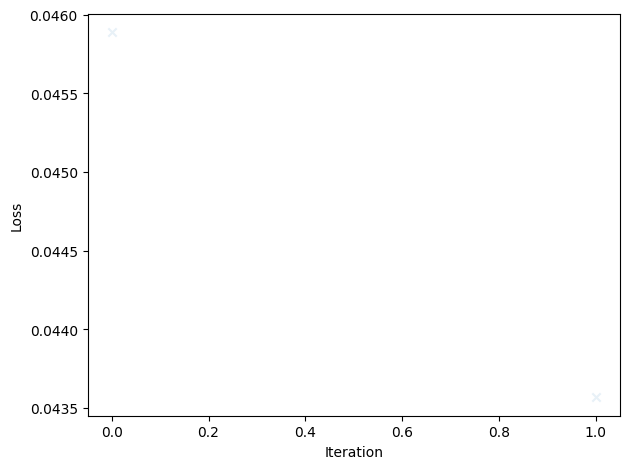

In [80]:
window = 10  # adjust as needed

fig, ax = plt.subplots(layout="tight")

to_graph = [history]
to_name = ["current"]

for i, (curve, name) in enumerate(zip(to_graph, to_name)):
    ax.scatter(range(len(curve)), curve, marker='x', alpha=0.1, color=f"C{i}")
    # ma_x = np.arange(window-1, len(curve))
    # moving_avg = np.convolve(curve, np.ones(window)/window, mode='valid')
    # ax.plot(ma_x, moving_avg, label=name, color=f"C{i}", alpha=0.5)
    
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
# ax.legend()
# ax.set_xlim(100, 800)
# ax.set_ylim(0, 0.05)

plt.show()

# Abations on training

I can do these now that I have a function to do the training process

## What views are used

In [312]:
result_target_ablation = list()
for option in ["none", "limited", "orthogonal"]:
    model = VGGT(
        tokenizer = IdentityTokenizer(),
        aggregator = Aggregator(embed_dim=256),
        depth_head = DepthHead(dim_in=512, activation=nn.Tanh())
    )
    model = model.to(device)
    print(f"Training: {option}")
    model, history = train_model(model, dataset, 10, 3, print_every=200, iterations=1000, rotation_mode="limited")
    print()
    result_target_ablation.append((option, model, history))

Training: none
i=0, loss=0.06820382922887802, time=0.75s
i=200, loss=0.022889476269483566, time=0.70s
i=400, loss=0.00552449282258749, time=0.71s
i=600, loss=0.004250416997820139, time=0.70s
i=800, loss=0.0029540907125920057, time=0.69s

Training: limited
i=0, loss=0.08481985330581665, time=0.76s
i=200, loss=0.044084370136260986, time=0.68s
i=400, loss=0.04545193910598755, time=0.69s
i=600, loss=0.043219003826379776, time=0.68s
i=800, loss=0.04267480969429016, time=0.69s

Training: orthogonal
i=0, loss=0.04827026277780533, time=0.78s
i=200, loss=0.015658164396882057, time=0.68s
i=400, loss=0.004402338061481714, time=0.70s
i=600, loss=0.0025291976053267717, time=0.71s
i=800, loss=0.0026942838449031115, time=0.70s



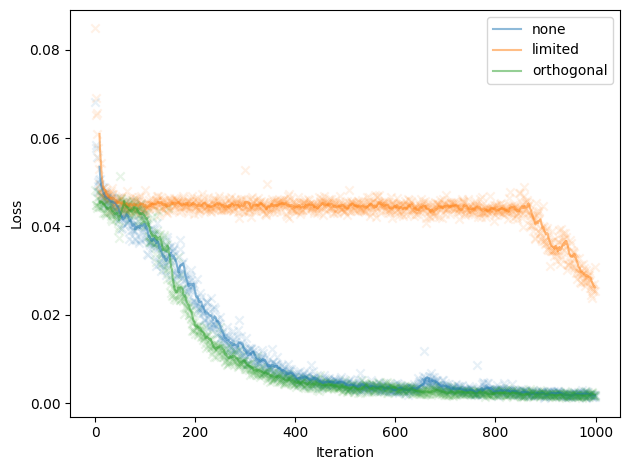

In [314]:
window = 10  # adjust as needed

fig, ax = plt.subplots(layout="tight")

for i, (option, _, curve) in enumerate(result_target_ablation):
    ax.scatter(range(len(curve)), curve, marker='x', alpha=0.1, color=f"C{i}")
    ma_x = np.arange(window-1, len(curve))
    moving_avg = np.convolve(curve, np.ones(window)/window, mode='valid')
    ax.plot(ma_x, moving_avg, label=option, color=f"C{i}", alpha=0.5)
    
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.legend()
# ax.set_xlim(100, 800)
# ax.set_ylim(0, 0.05)

plt.show()

# Timing the training

This was supposed to check which step of training took the longest

It may be outdated as I've made changes since

In [30]:
# Function to gauge how long it takes to do each step v.s. time

Ns = [1, 5, 10, 20, 30, 40, 60, 80, 100]
reps = 30
results = list()

for N in Ns:
    model = VGGT()
    model = model.to(device)
    
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())

    sub_results = list()

    for _ in trange(reps):        
        # Take a sample
        sample_start = time.perf_counter()
        sample, _, rotations = dataset.choose_events(N, 3)
        patch_counts, all_coords, all_patches = stack_patches(sample)
        patch_counts = torch.Tensor(patch_counts).int().to(device)
        all_coords = torch.Tensor(all_coords).int().to(device)
        all_patches = torch.Tensor(all_patches).to(device)
        sample_end = time.perf_counter()
    
        # Zero gradients
        optimizer.zero_grad()
        
        # Make predictions
        pred_start = time.perf_counter()
        predictions, test_output, patch_start_idx = model(patch_counts, all_coords, all_patches)
        pred_quaternions = predictions["pose_enc"]
        pred_end = time.perf_counter()
    
        # Compute the ground truth
        quaternions = torch.tensor(np.array([[r.as_quat() for r in row] for row in rotations])).to(device).float()
        
        # Run backprop
        backprop_start = time.perf_counter()
        loss = loss_fn(pred_quaternions, quaternions)
        loss.backward()
        optimizer.step()
        backprop_end = time.perf_counter()

        sub_results.append((sample_end-sample_start, pred_end-pred_start, backprop_end-backprop_start))
    results.append(sub_results)

100%|██████████| 30/30 [02:39<00:00,  5.31s/it]


In [31]:
results = np.array(results)

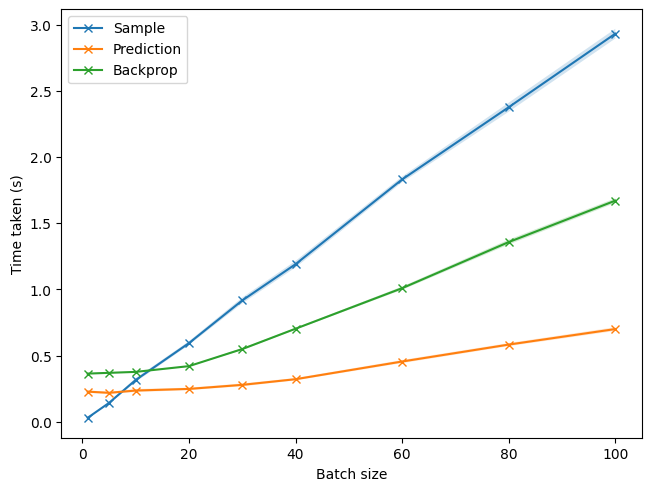

In [32]:
means = results.mean(axis=1)
std = results.std(axis=1, ddof=1)
sem = std / np.sqrt(results.shape[1])

labels = ["Sample", "Prediction", "Backprop"]

fig, ax = plt.subplots(layout="constrained")

for i in range(3):
    m = means[:, i]
    e = sem[:, i]
    ax.plot(Ns, m, label=labels[i], marker="x")
    ax.fill_between(Ns, m - e, m + e, alpha=0.2)

ax.set_xlabel("Batch size")
ax.set_ylabel("Time taken (s)")
ax.legend()
plt.show()

# Attempts at training an autoencoder

Was going to use an autoencoder framework to pretrain our tokenization network. I may come back to this later

In [91]:
sample, _, _ = dataset.choose_events(100, 3)

In [102]:
patches = torch.tensor(np.concatenate([x[2] for s in sample for x in s])).float().to(device)

In [103]:
tokenizer = Tokenizer().to(device)

In [105]:
tokenizer(patches).shape

torch.Size([11421, 256])